# Projeto de Clusterização de clientes de uma empresa de telefonia

<img src="imagem.jpg" height="400">

## ÍNDICE

* **1. Introdução**
* **2. Preparativos**
    * 2.1 Importação das bibliotecas necessárias
    * 2.2 Aquisição dos dados
    * 2.3 Funções auxiliares
* **3. Análise Exploratória dos Dados**
    * 3.1 Descrição das colunas
    * 3.2 Padronização dos tipos de dados
    * 3.3 Respostas às perguntas levantadas
    * 3.4 Análise Exploratória de Dados com Visualização
        * *3.4.1 Variáveis categóricas*
        * *3.4.2 Variáveis numéricas*
* **4. Preparação dos dados**
    * 4.1 Valores ausentes
    * 4.2 Normalização
* **5. Clusterização**
* **6. Resultados**
    * 6.1 Principais características de cada cluster
    * 6.2 Clusters e Rotatividade (Churn)
* **Conclusão**

# 1. Introdução

Neste projeto, procuramos analisar uma base de dados de uma empresa de telefonia, que contém informações referente aos seus clientes, como sexo, faixa etária, principais serviços contratados, quanto tempo cada um deles permaneceu com a empresa antes de deixá-la, se o cliente cancelou o serviço (churn), dentre outros aspectos. Assim, procuraremos responder às perguntas abaixo, a fim de obter mais informações:

**P1** - Qual o *churn rate* da empresa, isto é, qual a porcentagem de clientes que deixou o serviço?  
**P2** - Por quanto tempo em média, os clientes permanecem ativos antes de deixar a empresa?  
**P3** - Qual a porcetagem de clientes que deixa a empresa nos primeiros 10 meses?  
**P4** - Qual o valor de receita mensal arrecado das pessoas que *churnam*? Este valor corresponde a quantos porcento da receita mensal total?   
**P5** - Se fizéssemos uma campanha de marketing para aumentar o tempo de permanência do cliente (*tenure*) em 12 meses, com 100% de adesão dos clientes que churnam, qual seria o impacto dessa campanha na receita total dos clientes?

Em seguida, aplicamos um algoritmo de clusterização para segmentar os clientes em diferentes grupos e entender melhor as características de cada um.

# 2. Preparativos

## 2.1 Importação das bibliotecas necessárias

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from kmodes.kprototypes import KPrototypes


from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
#Para aumentar a quantidade de colunas que serão exibidas:

pd.set_option('display.max_columns',100)

## 2.2 Aquisição dos dados

A base de dados pode ser encontrada no Kaggle, neste [link]('https://www.kaggle.com/datasets/blastchar/telco-customer-churn').

In [11]:
data = pd.read_csv('telco.csv')
display(data.head())
display(data.shape)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


(7043, 21)

## 2.3 Funções auxiliares

Criamos uma função que nos auxiliará a separar as variáveis quanto aos tipos categóricas, numéricas e também a variável target:

In [12]:
def sep_var(data, col_to_drop, target):
    
    var_cat=[]
    var_num=[]
    target = target

    for col in data.drop(columns=col_to_drop).columns:
        if data[col].dtypes == object:
            var_cat.append(col)
        else:
            var_num.append(col)


    print(f'Há {len(var_cat)} variáveis categóricas.\n{var_cat}\n')
    print(f'Há {len(var_num)} variáveis numéricas.\n{var_num}\n')
    print(f'A variável target é {target}.')
    
    return var_cat, var_num, target

Abaixo, criamos também uma função para gerar os gráficos necessários.

In [13]:
def graph(var_type, hue='Churn', var = 'Churn', x=20, y=35, j=0):
    
    plt.figure(figsize=(x,y))
    
    n=len(var_type)//3 + 1
    
    for i, col in enumerate(data[var_type].columns,1):
        plt.subplot(n,3,i)
        
        if var_type == var_cat:
            sns.countplot(data=data, x=col, hue = hue, dodge = True).set_title(f'Gráfico {i+j}')
        
        if var_type == var_num:
            sns.boxplot(data=data, x = var, y = col).set_title(f'Gráfico {i+j}')          

# 3. Análise Exploratória de Dados

## 3.1 Descrição das colunas

In [14]:
display(data.shape)

(7043, 21)

Verificamos que o dataframe é composto por 7043 linhas e 21 colunas, onde vemos abaixo o significado de cada coluna, e os valores contido em cada uma:

|Feature | Significado  | Valores    | 
|---:|:-------------|:-----------|
| customerID | Identificação do Cliente  | inteiro       |
| gender |	Se o cliente é do sexo masculino ou feminino | (Male, Female) |
| SeniorCitizen |	Se o cliente é idoso ou não | (1, 0) |
|Partner| Se o cliente tem um parceiro ou não | (Yes, No)| 
|Dependents| Se o cliente tem dependentes ou não| (Yes, No)|
|tenure| Número de meses que o cliente permaneceu na empresa| inteiro| 
|PhoneService| Se o cliente tem atendimento telefônico ou não| (Yes, No)| 
|MultipleLines| Se o cliente tem várias linhas ou não| (Yes, No, No phone service)| 
|InternetService| Provedor de serviços de internet do cliente| (DSL, Fiber optic, No)| 
|OnlineSecurity| Se o cliente tem segurança online ou não| (Yes, No, No internet service)| 
|OnlineBackup| Se o cliente tem backup online ou não| (Yes, No, No internet service)| 
|DeviceProtection| Se o cliente tem proteção de dispositivo ou não| (Yes, No, No internet service)| 
|TechSupport| Se o cliente tem suporte técnico ou não| (Yes, No, No internet service)| 
|StreamingTV| Se o cliente tem streaming de TV ou não| (Yes, No, No internet service)| 
|StreamingMovies| Se o cliente tem streaming de filmes ou não| (Yes, No, No internet service)| 
|Contract| O prazo do contrato do cliente| (Month-to-month, One year, Two year) 
|PaperlessBilling| Se o cliente recebe fatura eletrônica ou não| (Yes, No)| 
|PaymentMethod| A forma de pagamento do cliente| (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))| 
|MonthlyCharges| O valor cobrado mensalmente do cliente| float|
|TotalCharges| O valor total cobrado do cliente| float|
|Churn| Se o cliente desistiu ou não| (Yes or No)|

## 3.2 Padronização dos tipos de dados

Vamos primeiramente verificar os tipos de dados de cada coluna:

In [15]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Como vimos na descrição das colunas, a variável **SeniorCitizen** contém valores 0 e 1, diferentemente das outras, que possuem valores Yes/No.  
Assim, vamos substituir os valores (0,1) por ('No', 'Yes'), a fim de padronizar com as demais colunas:

In [16]:
#Substituir os valores (0,1) por ('No', 'Yes')
data['SeniorCitizen'] = data['SeniorCitizen'].replace([0,1],['No','Yes'])

A variável **TotalCharges** é uma variável do tipo *float*,  mas está tipificada como *object*.  
Vamos corrigir o tipo desta feature:

In [17]:
#Primeiramente verificamos que existem 11 valores iguais a "  "
print(data['TotalCharges'].value_counts())

#Esses valores são substituídos por 'NaN'
data['TotalCharges'] = data['TotalCharges'].replace(' ',np.NaN)

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64


In [18]:
#Em seguida, corrigimos o tipo de dado da coluna 'TotalCharges' de 'object' para 'float':
data['TotalCharges'] = data['TotalCharges'].astype(float)

Uma vez que as correções necessárias estão finalizadas, vamos usar a função que criamos,'sep_var', para separar as variáveis em listas de variáveis categóricas, numéricas e target:

In [19]:
var_cat,var_num, target = sep_var(data, ['customerID', 'Churn'], 'Churn')

Há 16 variáveis categóricas.
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Há 3 variáveis numéricas.
['tenure', 'MonthlyCharges', 'TotalCharges']

A variável target é Churn.


## 3.3 Respostas às perguntas levantadas

### P1 - Qual o *churn rate* da empresa, isto é, qual a porcentagem de clientes que deixou o serviço?

In [20]:
#Vamos verificar a quantidade de clientes que deixam a empresa e que não deixam:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [24]:
print(f'P1: O churn rate da empresa é de {1869/(1869+5174):.2%}.')

P1: O churn rate da empresa é de 26.54%.


### P2 - Por quanto tempo em média, os clientes permanecem ativos antes de deixar a empresa?

In [26]:
media_tenure = data[data['Churn'] == 'Yes']['tenure'].mean()
mediana_tenure = data[data['Churn'] == 'Yes']['tenure'].median()

In [30]:
print(f'P2: A média de meses que o cliente leva para deixar a empresa é de {media_tenure:.2f} meses.\n\
A mediana corresponde a {mediana_tenure} meses.')

P2: A média de meses que o cliente leva para deixar a empresa é de 17.98 meses.
A mediana corresponde a 10.0 meses.


### P3 - Qual a porcetagem de clientes que deixa a empresa nos primeiros 10 meses?

In [31]:
#Primeiro aplicamos um filtro para obter a quantidade de clientes que churnam em até 10 meses
churn_10meses = data[(data['tenure']<=10) & (data['Churn']=='Yes')].shape[0]

In [33]:
print(f'P3: Nos 10 primeiros meses, {churn_10meses/data.shape[0] :.2%} dos clientes totais irão churnar.')

P3: Nos 10 primeiros meses, 13.74% dos clientes totais irão churnar.


### P4 - Qual o valor de receita mensal arrecadada das pessoas que churnam? Ela corresponde a quantos porcento da receita mensal total?

In [34]:
receita_mensal_churn = data[data['Churn'] == 'Yes']['MonthlyCharges'].sum()
receita_mensal_total = data['MonthlyCharges'].sum()

In [36]:
print(f'P4: O valor mensalmente arrecadado proveniente das pessoas que churnam é $ {receita_mensal_churn:,.2f}.\n\
Este valor corresponde a {receita_mensal_churn/receita_mensal_total:.2%} da receita mensal total.')

P4: O valor mensalmente arrecadado proveniente das pessoas que churnam é $ 139,130.85.
Este valor corresponde a 30.50% da receita mensal total.


### P5 - Se fizéssemos uma campanha de marketing para aumentar o tempo de permanência com a empresa (tenure) em 12 meses, com 100% de adesão dos clientes que churnam, qual seria o impacto dessa campanha na receita total dos clientes?

In [37]:
#Vamos criar uma coluna com os mesmos valores da coluna 'tenure' acrescido de 12 meses, 
#essa coluna hipotética conterá os valores da nova tenure
data['nova_tenure']=data['tenure'] + 12

#Assim, as receitas totais também aumentarão, considerando a nova tenure.
#Calculamos, então, os novos valores de 'TotalCharges':
data['novo_TotalCharges'] = data['nova_tenure']*data['MonthlyCharges']

#Finalmente visualizamos o dataframe com as novas informações
data[['tenure','nova_tenure','MonthlyCharges','TotalCharges','novo_TotalCharges','Churn']].head(5)

,tenure,nova_tenure,MonthlyCharges,TotalCharges,novo_TotalCharges,Churn
0,1,13,29.85,29.85,388.05,No
1,34,46,56.95,1889.50,2619.70,No
2,2,14,53.85,108.15,753.90,Yes
3,45,57,42.30,1840.75,2411.10,No
4,2,14,70.70,151.65,989.80,Yes


In [38]:
#Calculamos o valor total das receitas obtidas com cada cliente
#antes e depois da campanha de marketing
receita_total = data['TotalCharges'].sum()
receita_total_nova = data['novo_TotalCharges'].sum()

#calculamos o impacto percentual que a campanha de marketing trouxe
dif_percentual = (receita_total_nova - receita_total)/receita_total

print(f"O valor total das receitas de todos os clientes foi $ {receita_total:,.2f}.\n")
print(f"Se fizéssemos uma campanha de marketing para reter os clientes por, pelo menos, mais 12 meses, \
com 100% de adesão dos clientes que abandonariam a empresa, \
o valor total das receitas seria de $ {receita_total_nova:,.2f}, \n\
ou seja, de {dif_percentual:.2%} a mais.")


O valor total das receitas de todos os clientes foi $ 16,056,168.70.

Se fizéssemos uma campanha de marketing para reter os clientes por, pelo menos, mais 12 meses,com 100% de adesão dos clientes que abandonariam a empresa, o valor total das receitas seria de $ 21,528,490.65, 
ou seja, de 34.08% a mais.


## 3.4 Análise Exploratória de Dados com Visualização

Passamos agora à Análise Exploratória de Dados utilizando vizualização gráfica, visando extrair outros *insights*.

### 3.4.1 Variáveis categóricas

Vamos procurar analisar primeiramente as variáveis categóricas:

In [39]:
data[var_cat].describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365


Podemos constatar que a maioria das variáveis possuem apenas 2 ou 3 valores, com exceção para 'PaymentMethod', que possui 4, estando de acordo com a descrição prévia das colunas.

Vamos agora extrair outros *insights* a partir da visualização gráfica das variáveis categóricas:

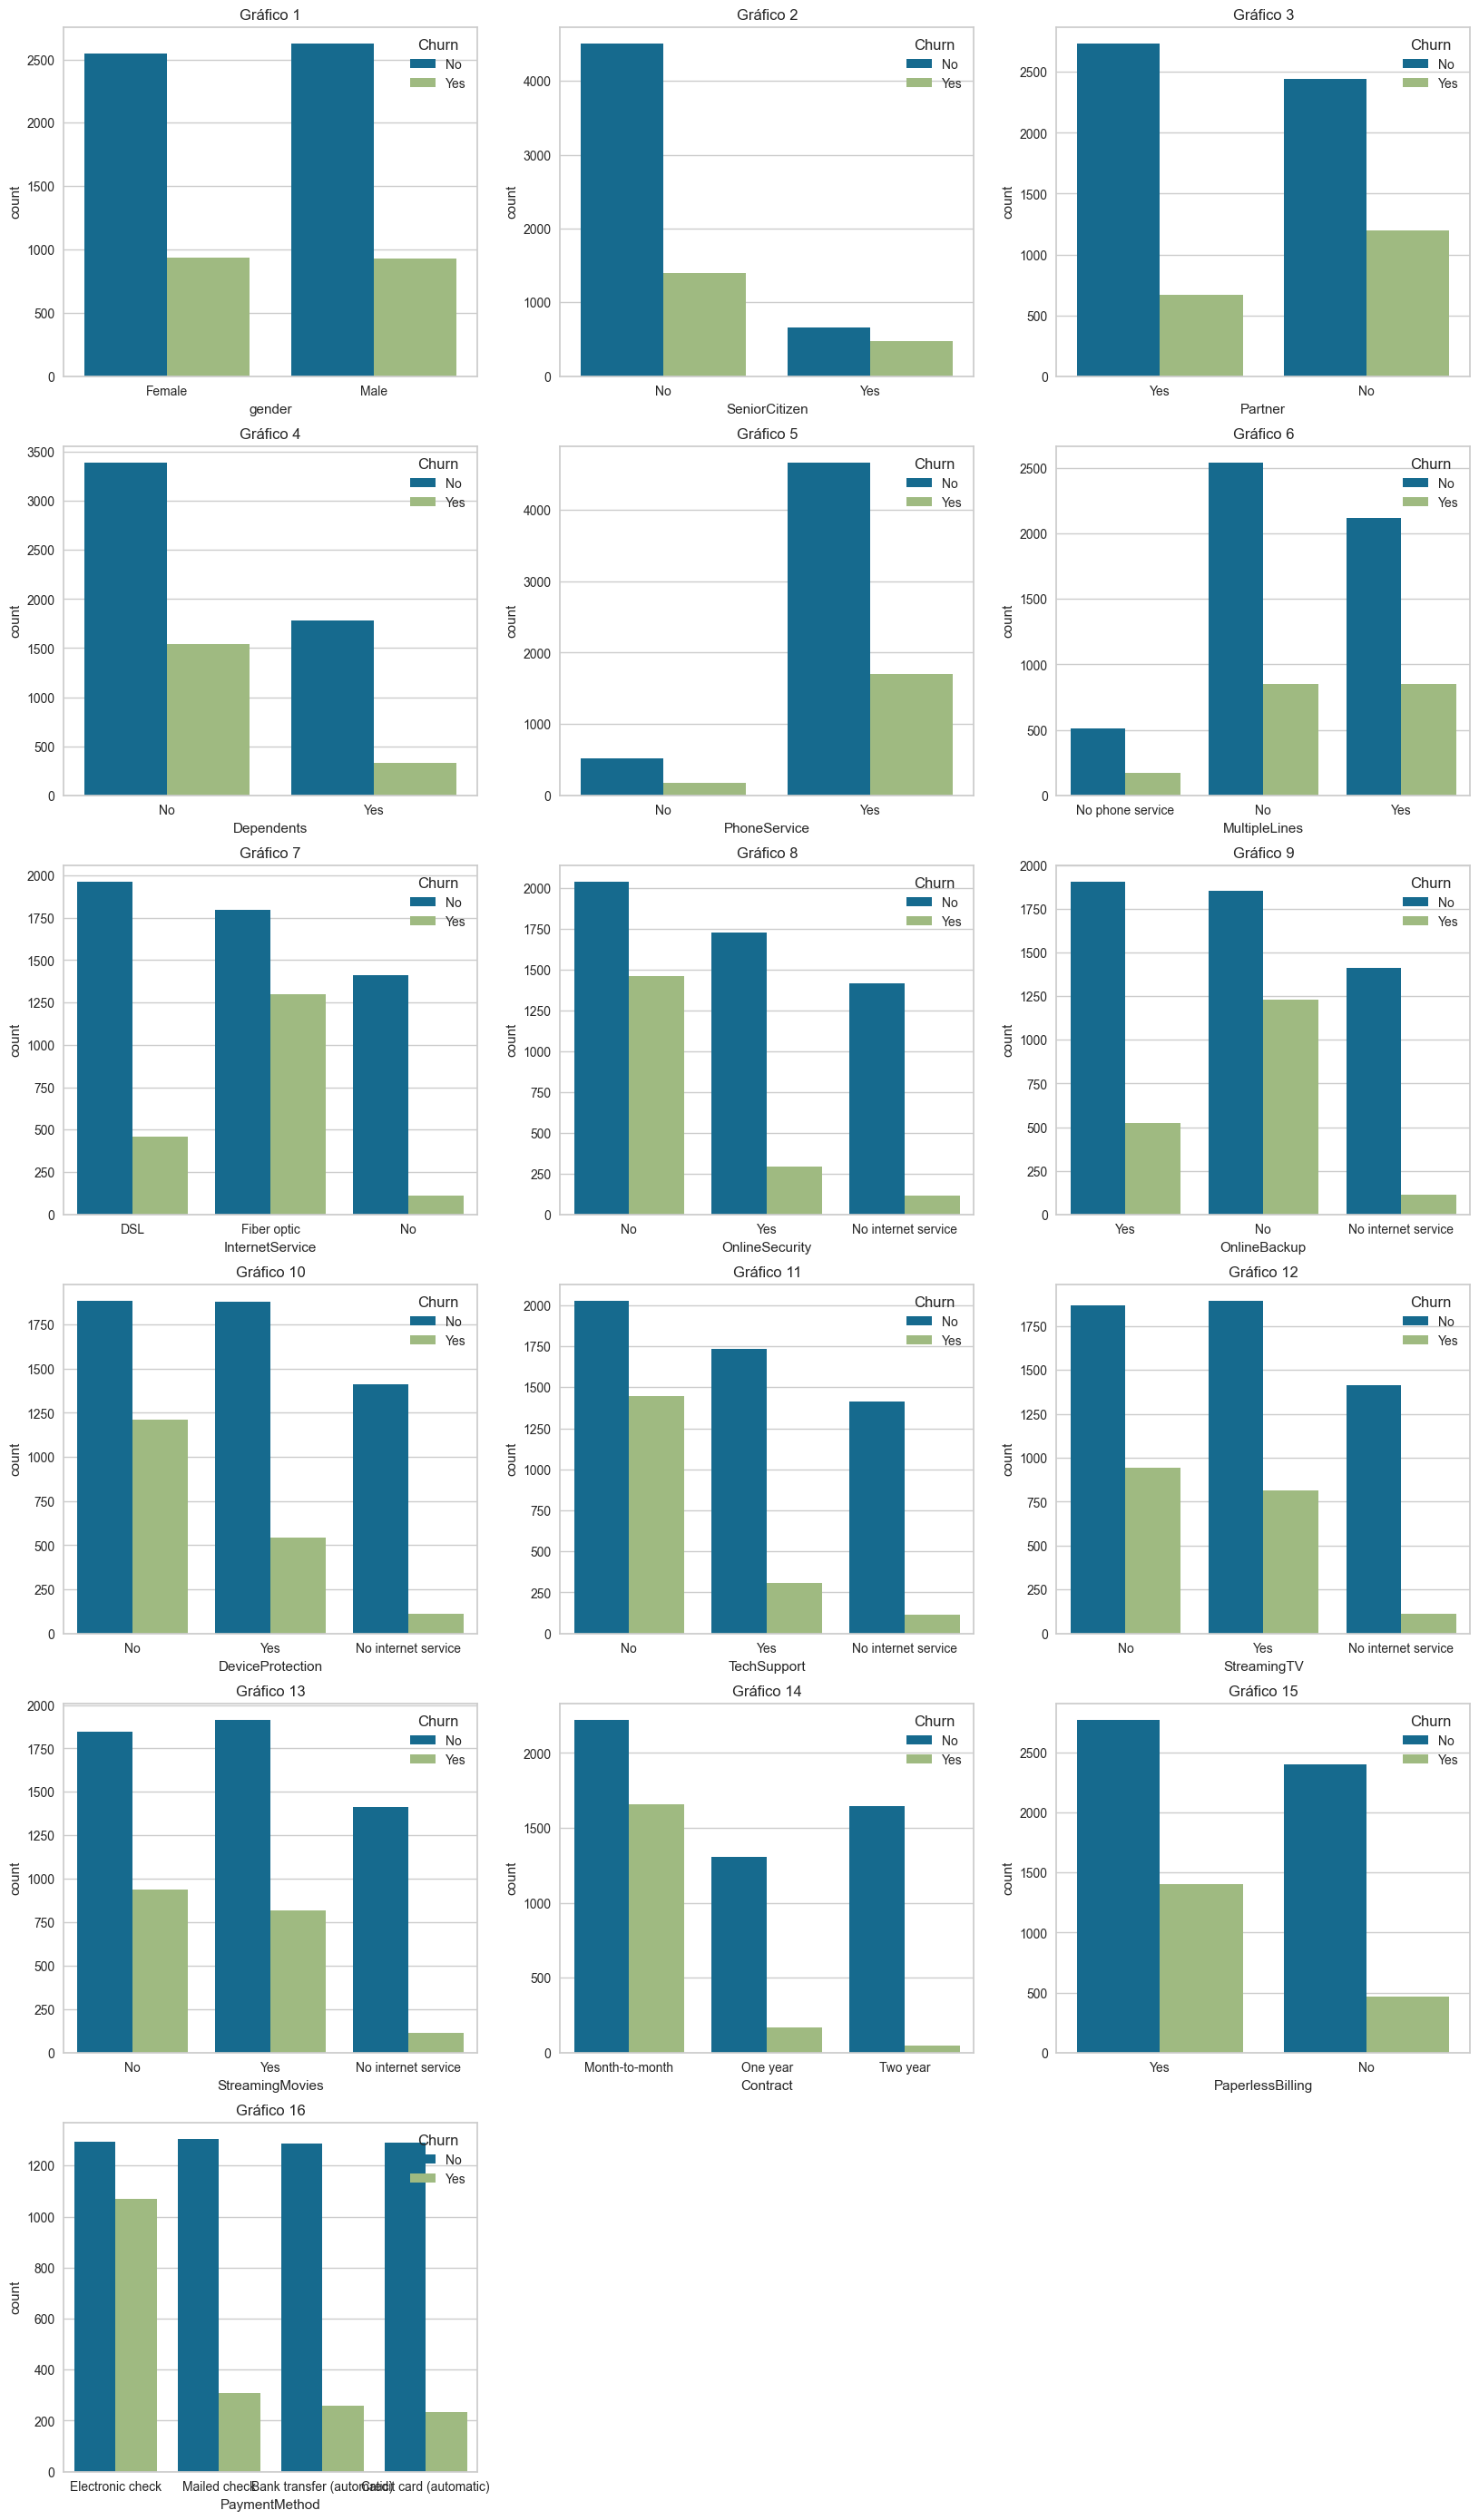

In [40]:
graph(var_cat)

Do Gráfico 1, observamos que o dataset possui aproximadamente a mesma quantidade de homens e mulheres, e que **o gênero não é relevante para determinar se o cliente irá deixar de operadora.**  

Do Gráfico 2, observamos que há muito menos idosos, no entanto, **grande parte deles irá deixar a empresa em algum momento.**  

Do Gráfico 3, vemos que, **proporcionalmente**, clientes que não têm parceiros churnam mais que clientes que têm parceiros.  

No Gráfico 4, podemos verificar que a quantidade de clientes que não possuem dependentes é pouco mais que a metade dos clientes que possuem, no entanto, a probabilidade destes últimos abandorarema a empresa é menor.  

No Gráfico 5, vemos que a maioria dos clientes posssuem serviços de telefone.

No Gráfico 6, podemos observar que o fato de possuir múltiplas linhas não muda consideravalmente a probabilidade de churnar.  

No Gráfico 7, podemos ver **que clientes que possuem *Fiber optic* (fibra óptica) churnam com mais facilidade.**  

No Gráfico 8, podemos verificar que clientes que não possuem *OnlineSecurity* churnam mais do que clientes que possuem.  

No Gráfico 9, fica claro que clientes que possuem *OnlineBackup* churnam menos do que clientes que não possuem.  

A partir dos Gráfico 10 e 11, podemos concluir que clientes que não possuem *DeviceProtection* e *TechSupport* churnam mais.  

Nos Gráficos 12 e 13, vemos que, possuir *StreamingTV* e *StreamingMovies* não é um fator relevante para o cliente decidir churnar.  

No Gráfico 14, vemos que **quanto maior o prazo do contrato, menos os clientes churnam.**

Do Gráfico 15, podemos concluir que **clientes que recebem fatura em meios que não utilizam papel churnam mais que clientes que recebem.**  

Do Gráfico 16, vemos que **clientes que utilizam meios eletrônicos para pagamentos churnam mais que clientes que utilizam outros meios.**

### 3.4.2 Variáveis numéricas

Vamos analisar, agora, as variáveis numéricas:

In [41]:
data[var_num].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


A partir da descrição dos acima, verificamos que o tempo médio de permanência dos clientes neste dataset é de aproximadamente 32 meses, e que o cliente que está a mais tempo possui tenure de 72 meses.  

Verificamos também que o valor médio mensalmente pago pelos clientes é de $ 64.76. Além disso, constamos que a coluna 'TotalCharges' é aproximadamente o produto das colunas 'tenure' e 'MonthlyCharges'.

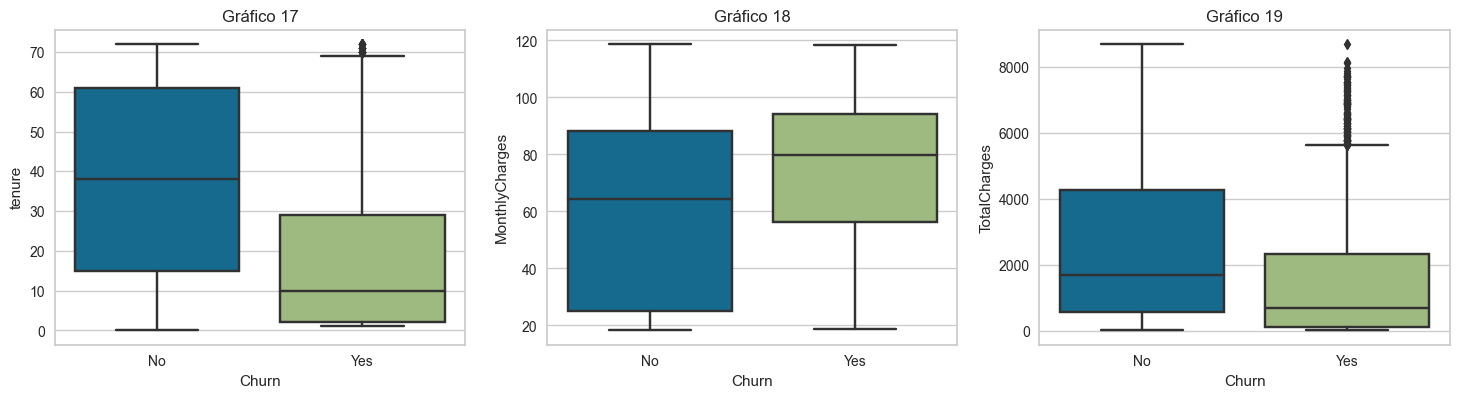

In [42]:
graph(var_num, x=18, y=9, j=16)

Do Gráfico 17, podemos observar que a mediana de tempo que as pessoas permanecem com a empresa é 10 meses, **ou seja, 50% dos clientes que churnam, o farão nos 10 primeiros meses.**  

No Gráfico 18, podemos verificar que **as pessoas que churnam tem a mediana de pagamento mensal superior às pessoas que não churnam.**  

Como era razoável de se esperar, o valor total pago pelas pessoas que permanecem com a empresa é maior do que o valor pago pelas pessoas que a abandonam, conforme podemos ver no Gráfico 19.

## 4 Preparação dos dados

Antes de aplicar a Clusterização, precisamos preparar os dados, a fim de evitar que trabalhemos com valores ausentes, e também com escalas diferentes para as features numéricas, uma vez que isso pode levar o algoritmo a não realizar a modelagem de maneira adequada, e por fim, nos levar a interpretar equivocadamente os resultados.

Assim, vamos criar um novo dataframe chamado X, com as colunas categóricas e numéricas, no entanto, sem a coluna Churn. O objetivo aqui é que o algoritmo não leve em conta se o cliente churnou o não, mas sim entender as características de um novo usuário que se torna cliente da empresa.

In [68]:
X = data[var_cat+var_num]
X.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,1,29.85,29.85
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,34,56.95,1889.50
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,2,53.85,108.15
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),45,42.30,1840.75
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,2,70.70,151.65


## 4.1 Valores ausentes

Vamos verificar se há valores ausentes:

In [69]:
X.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
tenure               0
MonthlyCharges       0
TotalCharges        11
dtype: int64

A única feature que apresenta valores ausentes é 'TotalCharges'.  Vamos substituir esses valores pela mediana:

In [70]:
X["TotalCharges"].fillna(X["TotalCharges"].median(), inplace=True)

C:\Users\Hermann\AppData\Local\Temp\ipykernel_14328\841702394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["TotalCharges"].fillna(X["TotalCharges"].median(), inplace=True)


## 4.2 Normalização

Por se tratar de algoritmos que levam em consideração as distâncias entre os pontos distribuidos no espaço, precisamos também aplicar algum tipo de normalização, para que fiquem na mesma escala. Aqui, usamos o 'StandardScaler':

In [71]:
scaler = StandardScaler()

X[var_num] = scaler.fit_transform(X[var_num])

C:\Users\Hermann\AppData\Local\Temp\ipykernel_14328\783420003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[var_num] = scaler.fit_transform(X[var_num])


Nosso dataset preparado se encontra abaixo:

In [27]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,-1.277445,-1.160323,-0.994242
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,0.066327,-0.259629,-0.173244
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,-1.236724,-0.362660,-0.959674
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),0.514251,-0.746535,-0.194766
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,-1.236724,0.197365,-0.940470


Agora que nosso dataset está preparado, passaremos a etapa posterior de clusterização utilizando o K-prototypes.

# 5 Clusterização

Quando possuímos um dataset que contém variáveis categóricas e numéricas, a utilização do algoritmo K-means pode não ser a mais adequada, uma vez que este método leva em consideração apenas variáveis numéricas. No entanto, existe outro algoritmo, chamado de K-prototypes, que basicamente mistura os princípios do K-means e do K-modes para chegar a melhores resultados (enquanto o K-means realiza o agrupamento dos dados numéricos baseado nas distâncias entre eles, o K-modes agrupa os dados com base na semelhança das categorias).

Para usar o K-prototypes, devemos primeiramente criar uma lista contendo os índices das variáveis categóricas, pois essa informação é necessária ao modelo:

In [72]:
var_cat_index =[i for i in range(0,16)]
var_cat_index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Em seguida, iteramos sobre o número de clusters que queremos analisar, no nosso caso, de 2 a 9, e calculamos a função custo para cada quantidade de clusters. Esta função pode ser definida como a soma das distâncias de todos os pontos às respectivas centróides.

In [73]:
n_clusters = [n for n in range(2,10)]
cost =[]

for n in n_clusters:
    print(f'Calculando para n = {n}...')
    kproto = KPrototypes(n_clusters= n)
    clusters = kproto.fit_predict(X, categorical = var_cat_index)
    cost.append(kproto.cost_)

print('Fim.')

Calculando para n = 2...
Calculando para n = 3...
Calculando para n = 4...
Calculando para n = 5...
Calculando para n = 6...
Calculando para n = 7...
Calculando para n = 8...
Calculando para n = 9...
Fim.


In [78]:
for i in range(8):
    print(f"Número de clusters: {n_clusters[i]}, Custo: {cost[i]}")

Número de clusters: 2, Custo: 32864.52582950917
Número de clusters: 3, Custo: 23874.374446463084
Número de clusters: 4, Custo: 21720.987394064592
Número de clusters: 5, Custo: 20052.44608161759
Número de clusters: 6, Custo: 18572.41801004721
Número de clusters: 7, Custo: 17539.568165609857
Número de clusters: 8, Custo: 17012.966151021614
Número de clusters: 9, Custo: 16465.72459572659


Uma vez que calculamos os custos para cada número de clusters, podemos plotar o gráfico Custo x Número de Clusters e utilizar o Método do Cotovelo para encontrar o valor ótimo para o número de clusters. Este valor pode ser caracterizado como o valor a partir do qual a inclinação da curva muda abruptamente.

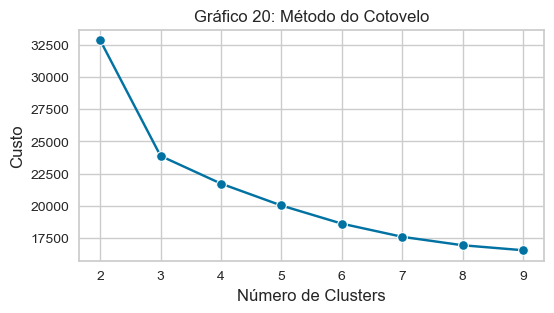

In [30]:
plt.figure(figsize=(6,3))
ax = sns.lineplot(x=n_clusters, y=cost, marker='o')
ax.set_xlabel( "Número de Clusters" , size = 12 ) 
ax.set_ylabel( "Custo" , size = 12 ) 
ax.set_title( "Gráfico 20: Método do Cotovelo" , size = 12 ) 
plt.show()

Podemos perceber que ocorre uma grande variação na taxa de decaimento do custo quando o número de clusters é igual a 3, sendo esse o valor ótimo definido pelo modelo. Assim, usamos n=3 para calcular em que cluster cada cliente estará:

In [79]:
kproto = KPrototypes(n_clusters= 3)
clusters = kproto.fit_predict(X, categorical = var_cat_index)
clusters

array([0, 0, 0, ..., 0, 0, 1], dtype=uint16)

In [80]:
data['Cluster'] = clusters
 
#obs: Também excluimos as colunas 'nova_tenure' e 'novo_TotalCharges':
data.drop(columns=['nova_tenure','novo_TotalCharges'], inplace=True)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Cluster
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,2
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


# 6 Resultados

Os resultados são mostrados a seguir.

## 6.1 Principais características de cada cluster

No Gráfico 21, observamos as distribuições dos clusters de acordo com as características das colunas 'MonthlyCharges' e 'tenure'.

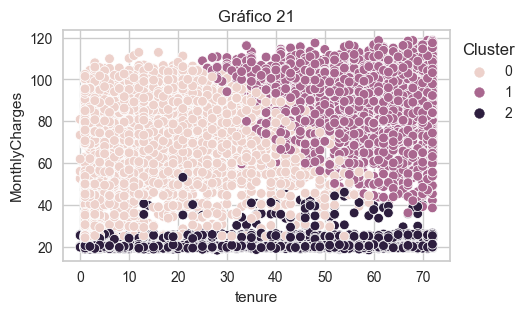

In [81]:
plt.figure(figsize=(5,3))
ax = sns.scatterplot(data=data, x= 'tenure', y='MonthlyCharges', hue='Cluster')
ax.set_title(f'Gráfico 21')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

No Gráfico 22, observamos as distribuições dos clusters de acordo com as características das colunas 'TotalCharges' e 'tenure'.

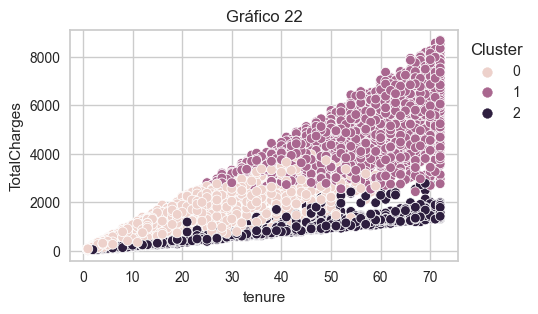

In [83]:
plt.figure(figsize=(5,3))
ax = sns.scatterplot(data=data, x= 'tenure', y='TotalCharges', hue='Cluster')
ax.set_title(f'Gráfico 22')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Abaixo, agrupamos os dados por cluster para podermos obter as médias e medianas das colunas "tenure", "MonthlyCharges" e "TotalCharges".

In [96]:
display(data.groupby('Cluster')[var_num].median())
display(data.groupby('Cluster')[var_num].mean())

,tenure,MonthlyCharges,TotalCharges
Cluster,,,
0,12.0,71.10,819.550
1,61.0,93.45,5116.600
2,27.0,20.20,572.625


,tenure,MonthlyCharges,TotalCharges
Cluster,,,
0,15.476758,69.127523,1074.886799
1,58.605517,89.744713,5246.843448
2,31.235294,21.824061,712.800754


E finalmente visualizamos o boxplot de cada cluster, para cada característica numérica:

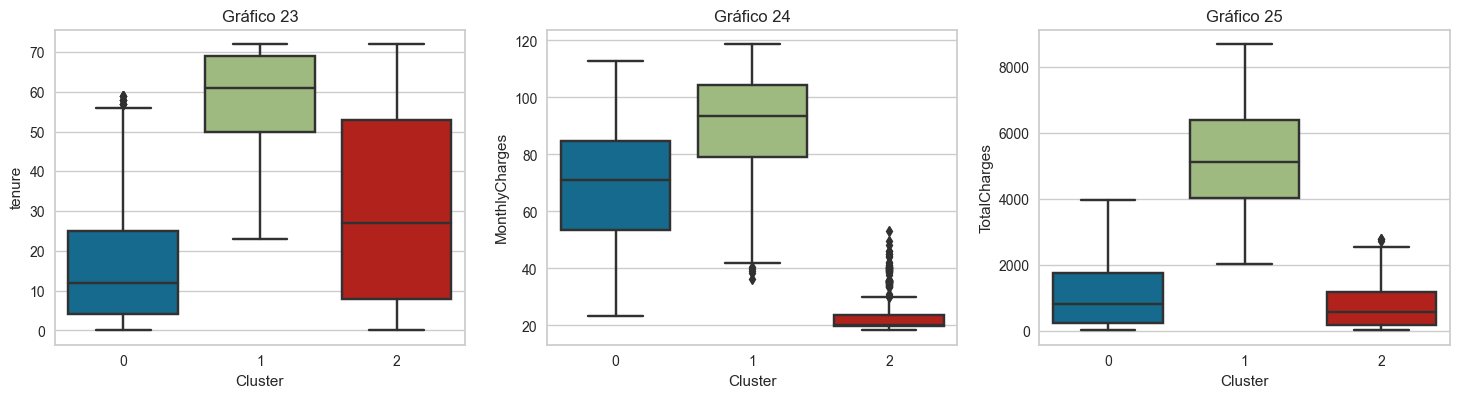

In [97]:
graph(var_num, x=18, y=9, var = 'Cluster', j=22)

Podemos concluir que:

- **Cluster 0**: possui, em média, o menor tempo de permanência com a empresa (menor tenure), mas possui altos valores de cobrança mensal.
- **Cluster 1**: possui o maior tempo de permanência com a empresa e os maiores valores de cobrança mensal e, portanto, são os **clientes que mais trazem receita para a empresa**.
- **Cluster 2**: possui o tempo de permanência com a empresa médio, e os menores valores de cobrança mensal e menores valores de cobrança, ao longo da vida como cliente. 

## 6.2 Clusters e Rotatividade (Churn)

Vamos analisar também o comportamento de cada cluster de acordo com o Churn:

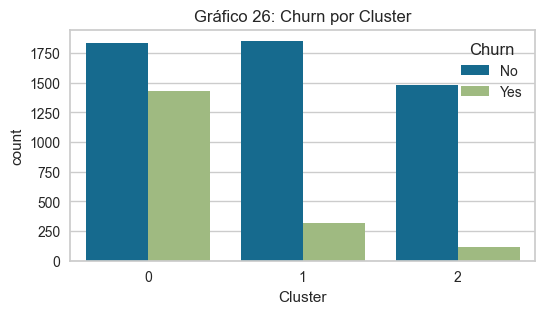

In [98]:
plt.figure(figsize=(6,3))
sns.countplot(data=data, x='Cluster', hue = 'Churn', dodge = True)
plt.title('Gráfico 26: Churn por Cluster')
plt.show()

De acordo com o Gráfico 26, fica claro que o grupo que apresenta o maior Churn Rate é o cluster 0, seguido dos clusters 1 e 2.

# Conclusão

Neste projeto, analisamos os dados de uma empresa de telecomunicação, com relação as características de seus clientes, como gênero, principais serviços contratados, quantidade de meses em que são ou foram clientes, índice de rotatividade e outros. 

Da Análise Exploratória de Dados, pudemos extrair várias informações importantes, como:

- 26,54% dos clientes abandonam a empresa;
- dentre os clientes que deixam a empresa, a média de meses que eles ficam como clientes é de 17,98 meses;
- do total de clientes, 13,74% deixam a empresa nos 10 primeiros meses;
- a receita mensal arrecada dos clientes que churnam corresponde a 30,50% da receita mensal total.
- campanhas de retenção dos clientes por períodos de 12 meses teriam a capacidade de aumentar a receita em até 34,08% (caso houvesse eficiência de 100%).

Outras conclusões interessantes são que:
- quase metade dos idosos churnam em algum momento;
- quanto maior o prazo dos contratos, menor o índice de churn;
- clientes que utilizam meios de pagamento eletrônicos churnam mais.

Os clientes foram divididos em 3 clusters (0, 1 e 2) através de clusterização realizada com o algoritmo 'K-prototypes'. Concluímos também que:
- quase metade dos clientes pertencentes ao cluster 0 abandonaria a empresa em algum momento;
- o cluster 1 apresenta clientes bastante interessantes, pois além de permanecer bastante tempo com a empresa, eles possuem os maiores valores de cobrança mensal, resultando em um alto Lifetime value.
